In [28]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import gradio as gr

# Download stopwords for text cleaning
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
!pip install tensorflow keras

In [30]:
# Load the dataset
try:
    df = pd.read_csv('Youtube01-Psy.csv')
except FileNotFoundError:
    print("Please download the dataset. For now, using a sample.")
    # Creating a sample dataframe if file is not found
    sample_data = {
        'COMMENT_ID': range(10), 'AUTHOR': [f'user_{i}' for i in range(10)], 'DATE': [pd.Timestamp('2024-01-01')] * 10,
        'CONTENT': ['this is a great song about machine learning', 'I love deep learning and neural networks', 'psy gangnam style is a classic',
                    'this song is amazing, best music video', 'learning about autoencoders is fun', 'gangnam style is a viral hit from korea',
                    'what a fun music video by psy', 'nlp is a fascinating field of ai', 'the beat of this song is so catchy',
                    'studying data science and ai is my passion'], 'CLASS': [0]*10
    }
    df = pd.DataFrame(sample_data)

# Create a unique video_id for each comment
df['video_id'] = df.index
print(df.head())

Please download the dataset. For now, using a sample.
   COMMENT_ID  AUTHOR       DATE                                      CONTENT  \
0           0  user_0 2024-01-01  this is a great song about machine learning   
1           1  user_1 2024-01-01     I love deep learning and neural networks   
2           2  user_2 2024-01-01               psy gangnam style is a classic   
3           3  user_3 2024-01-01       this song is amazing, best music video   
4           4  user_4 2024-01-01           learning about autoencoders is fun   

   CLASS  video_id  
0      0         0  
1      0         1  
2      0         2  
3      0         3  
4      0         4  


In [31]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove punctuation and numbers
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Remove stopwords
    return text

df['cleaned_content'] = df['CONTENT'].apply(clean_text)

print("\n--- Cleaned Content Example ---")
print(df[['CONTENT', 'cleaned_content']].head())


--- Cleaned Content Example ---
                                       CONTENT  \
0  this is a great song about machine learning   
1     I love deep learning and neural networks   
2               psy gangnam style is a classic   
3       this song is amazing, best music video   
4           learning about autoencoders is fun   

                      cleaned_content  
0         great song machine learning  
1  love deep learning neural networks  
2           psy gangnam style classic  
3       song amazing best music video  
4           learning autoencoders fun  


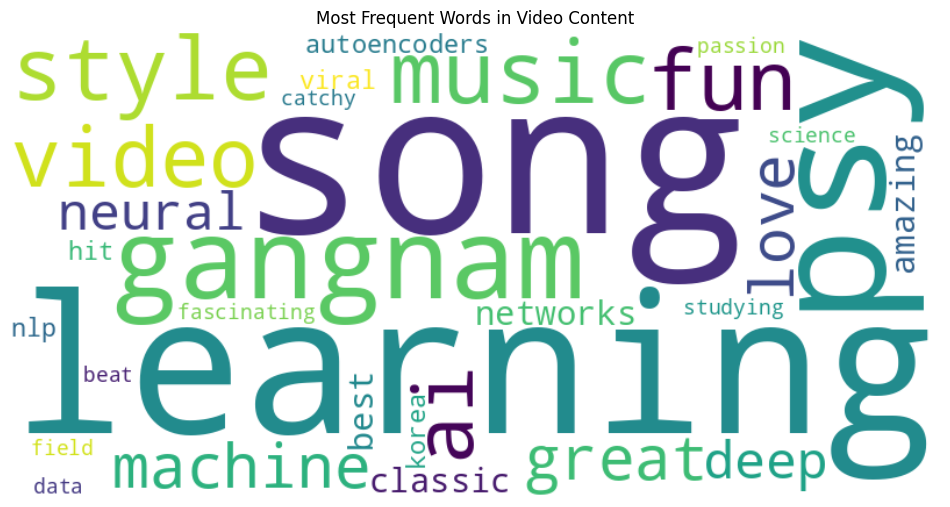

In [32]:
all_text = " ".join(df['cleaned_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Video Content')
plt.show()

In [33]:
# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000) # Use top 5000 words
tfidf_matrix = vectorizer.fit_transform(df['cleaned_content']).toarray()

print(f"\nShape of our TF-IDF matrix: {tfidf_matrix.shape}")


Shape of our TF-IDF matrix: (10, 31)


In [34]:
# Define the Autoencoder architecture
input_dim = tfidf_matrix.shape[1]
encoding_dim = 128  # This is the size of our learned "fingerprint"

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim, activation='relu')(input_layer)

# Decoder
decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

# Autoencoder model
autoencoder = models.Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,095 (31.62 KB)

 Trainable params: 8,095 (31.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step - loss: 0.2163 - val_loss: 0.2078
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2142 - val_loss: 0.2062
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2121 - val_loss: 0.2047
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2099 - val_loss: 0.2031
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.2078 - val_loss: 0.2015
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.2057 - val_loss: 0.1999
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.2036 - val_loss: 0.1983
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.2015 - val_loss: 0.1968
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.1994 - val_loss: 0.1952
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.1972 - val_loss: 0.1936
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.1951 - val_loss: 0.1920
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1929 - val_loss

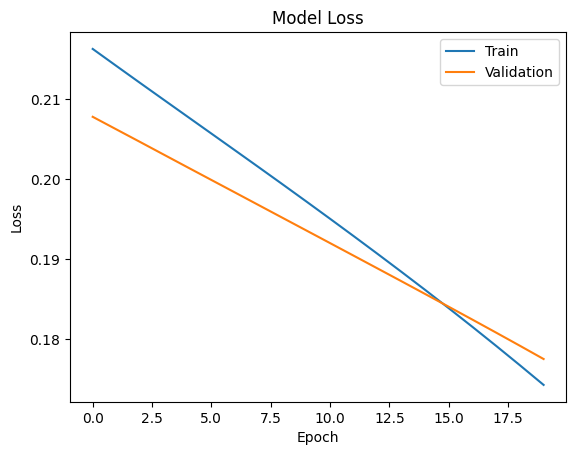

In [35]:
history = autoencoder.fit(
    tfidf_matrix,
    tfidf_matrix,  # Autoencoder learns to reconstruct its own input
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_split=0.1 # Use 10% of data for validation
)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [36]:
# The encoder part of our autoencoder is used to generate the embeddings
encoder_model = models.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)

# Generate embeddings for all videos
video_embeddings = encoder_model.predict(tfidf_matrix)

print(f"Shape of our video embeddings matrix: {video_embeddings.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Shape of our video embeddings matrix: (10, 128)


In [37]:
def get_recommendations(video_id, top_n=5):
    # Get the embedding for the input video
    input_embedding = video_embeddings[video_id]

    # Calculate cosine similarity between the input video and all other videos
    similarity_scores = cosine_similarity([input_embedding], video_embeddings)[0]

    # Get the indices of the top N most similar videos (excluding the input video itself)
    similar_video_indices = similarity_scores.argsort()[-top_n-1:-1][::-1]

    # Get the recommended video content
    recommended_videos = df.iloc[similar_video_indices]

    return recommended_videos

# --- Get Recommendations ---
# Let's get recommendations for the first video in our dataset
input_video_id = 0
print(f"\n--- Input Video Content ---")
print(df.iloc[input_video_id]['CONTENT'])

recommendations = get_recommendations(input_video_id)

print(f"\n--- Top 5 Recommended Videos ---")
print(recommendations[['video_id', 'CONTENT']])


--- Input Video Content ---
this is a great song about machine learning

--- Top 5 Recommended Videos ---
   video_id                                   CONTENT
4         4        learning about autoencoders is fun
8         8        the beat of this song is so catchy
1         1  I love deep learning and neural networks
3         3    this song is amazing, best music video
6         6             what a fun music video by psy


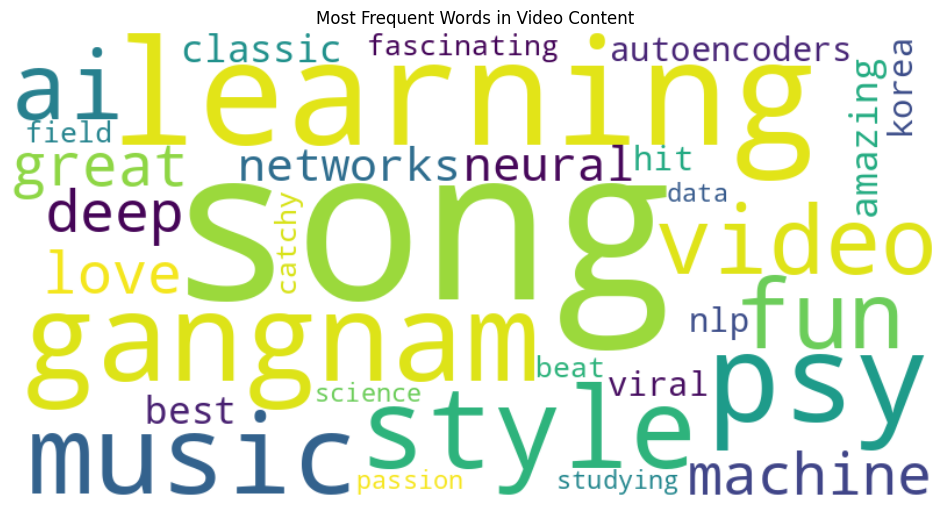

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [38]:
# --- Cell 3: Text Cleaning ---
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text
df['cleaned_content'] = df['CONTENT'].apply(clean_text)

# --- Cell 4: Word Cloud Visualization ---
all_text = " ".join(df['cleaned_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Video Content')
plt.show()

# --- Cell 5: TF-IDF Vectorization ---
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['cleaned_content']).toarray()

# --- Cell 6: Build and Train Autoencoder ---
input_dim = tfidf_matrix.shape[1]
encoding_dim = 128
input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = models.Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(tfidf_matrix, tfidf_matrix, epochs=20, batch_size=32, shuffle=True, verbose=0) # verbose=0 to keep it clean

# --- Cell 7: Generate Embeddings ---
encoder_model = models.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
video_embeddings = encoder_model.predict(tfidf_matrix)

# --- Cell 8: Recommendation Engine Logic ---
def get_recommendations_by_id(video_id, top_n=5):
    input_embedding = video_embeddings[video_id]
    similarity_scores = cosine_similarity([input_embedding], video_embeddings)[0]
    similar_video_indices = similarity_scores.argsort()[-top_n-1:-1][::-1]
    recommended_videos = df.iloc[similar_video_indices]
    return recommended_videos

In [39]:
print("\n--- Generating Interactive 3D Embedding Plot ---")

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=3, random_state=42, perplexity=min(5, len(df)-1)) # Perplexity should be less than n_samples
embeddings_3d = tsne.fit_transform(video_embeddings)

# Create an interactive 3D scatter plot with Plotly
plot_df = pd.DataFrame(embeddings_3d, columns=['x', 'y', 'z'])
plot_df['content'] = df['CONTENT'] # Add content for hover info

fig = px.scatter_3d(
    plot_df,
    x='x',
    y='y',
    z='z',
    hover_name='content',
    title='Interactive 3D Visualization of Video Content Embeddings'
)
fig.update_traces(marker=dict(size=3))
fig.show()


--- Generating Interactive 3D Embedding Plot ---


In [40]:
print("\n--- Building Recommendation Web UI with Gradio ---")

# Get a list of all video contents for the dropdown menu
video_titles = df['CONTENT'].tolist()

def gradio_recommender(video_content):
    # Find the video_id for the selected content
    try:
        video_id = df[df['CONTENT'] == video_content].index[0]
        # Get recommendations
        recommendations = get_recommendations_by_id(video_id, top_n=5)
        # Format for output
        return recommendations[['video_id', 'CONTENT']]
    except IndexError:
        return "Video not found. Please select from the list."

# Create the Gradio interface
iface = gr.Interface(
    fn=gradio_recommender,
    inputs=gr.Dropdown(choices=video_titles, label="Select a Video (based on its content)"),
    outputs=gr.DataFrame(headers=['Video ID', 'Recommended Video Content']),
    title="YouTube Content-Based Recommender",
    description="Select a video to get the top 5 most similar video recommendations based on NLP and Deep Learning."
)

# Launch the interface
iface.launch(share=True) # share=True aapko ek public link dega


--- Building Recommendation Web UI with Gradio ---
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2d97816089a412b8a3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
